In [ ]:
from typing import Final
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
words: Final[list[str]] = open("names.txt", 'r').read().splitlines()
chars: Final[list[str]] = sorted(list(set(''.join(words))))
stoi: Final[dict[str, int]] = {char: i + 1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos: Final[dict[int, str]] = {i: char for char, i in stoi.items()}
char_cnt: Final[int] = len(stoi)


In [4]:
def create_dataset(words: list[str], block_size: int) -> tuple[torch.Tensor, torch.Tensor]:
    X: list[list[int]] = []
    Y: list[int] = []
    for word in words:
        context: list[int] = [0] * block_size
        for ix in word + '.':
            X.append(context)
            Y.append(stoi[ix])
            context = context[1:] + [stoi[ix]]
    X_t = torch.tensor(X)
    Y_t = torch.tensor(Y)
    print(X_t.shape, Y_t.shape)
    return torch.tensor(X), torch.tensor(Y)


In [5]:
device: Final[torch.device] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
import random
random.seed(42)
random.shuffle(words)

block_size: Final[int] = 3 # context length
train_set_ratio: float = 0.8
valid_set_ratio: float = 0.1
test_set_ratio: float = 0.1

n1: int = int(len(words) * train_set_ratio)
n2: int = int(len(words) * (train_set_ratio + valid_set_ratio))

X_train, Y_train = create_dataset(words[:n1], block_size)
X_val, Y_val = create_dataset(words[n1:n2], block_size)
X_test, Y_test = create_dataset(words[n2:], block_size)

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


parameters: 38667
Epoch: 0, Loss: 43.087852478027344
Epoch: 1000, Loss: 7.984552383422852
Epoch: 2000, Loss: 5.261560916900635
Epoch: 3000, Loss: 4.189382076263428
Epoch: 4000, Loss: 3.095643997192383
Epoch: 5000, Loss: 4.575451850891113
Epoch: 6000, Loss: 4.343716144561768
Epoch: 7000, Loss: 2.5760393142700195
Epoch: 8000, Loss: 2.7942562103271484
Epoch: 9000, Loss: 2.761939287185669
Epoch: 10000, Loss: 2.990607976913452
Epoch: 11000, Loss: 3.0903477668762207
Epoch: 12000, Loss: 2.285999298095703
Epoch: 13000, Loss: 2.57346773147583
Epoch: 14000, Loss: 2.0277316570281982
Epoch: 15000, Loss: 2.673060417175293
Epoch: 16000, Loss: 2.293611764907837
Epoch: 17000, Loss: 2.253631114959717
Epoch: 18000, Loss: 2.404871940612793
Epoch: 19000, Loss: 2.765960693359375
Epoch: 20000, Loss: 2.2704458236694336
Epoch: 21000, Loss: 2.557609796524048
Epoch: 22000, Loss: 2.0790250301361084
Epoch: 23000, Loss: 2.6161744594573975
Epoch: 24000, Loss: 2.345709800720215
Epoch: 25000, Loss: 2.115846633911133


Text(0, 0.5, 'Loss (log10)')

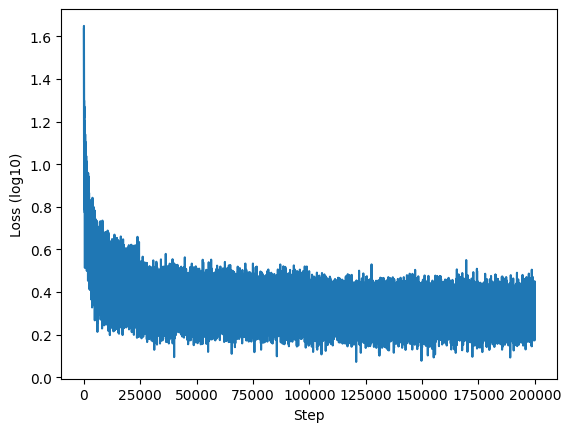

In [ ]:
num_neurons: Final[int] = 300
embed_dim: Final[int] = 30

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((char_cnt, embed_dim), generator=g).to(device)
W0 = torch.randn((block_size * embed_dim, char_cnt), generator=g).to(device)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g).to(device)
b1 = torch.randn(num_neurons, generator=g).to(device)
W2 = torch.randn((num_neurons, char_cnt), generator=g).to(device)
b2 = torch.randn(char_cnt, generator=g).to(device)

parameters = [C, W0, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(f"parameters: {sum(p.nelement() for p in parameters)}")

@torch.no_grad()
def calculate_loss(X_t: torch.Tensor, Y_t: torch.Tensor) -> torch.Tensor:
    emb = C[X_t]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    # emb.view(-1, block_size * embed_dim) @ W0: Direct connection from
    # the input to the output.
    logits = b2 + emb.view(-1, block_size * embed_dim) @ W0 + h @ W2
    return F.cross_entropy(logits, Y_t)

epochs: Final[int] = 200000
loss = torch.tensor(1000.0)
reg_strength: Final[float] = 0.006
mini_batch_size: Final[int] = 32

lossi: list[float] = []
stepi = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = b2 + emb.view(-1, block_size * embed_dim) @ W0 + h @ W2
    # regularization = torch.tensor([w.pow(2).mean() for w in [W0, W1, b1, W2, b2]]).mean() * reg_strength
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch} / {epochs}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = (0.1 if epoch < 25000 else
          0.05 if epoch < 100000 else
          0.01 if epoch < 150000 else
          0.005 if epoch < 180000 else
          0.001)

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    stepi.append(epoch)
    lossi.append(loss.log10().item())

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")

plt.plot(stepi, lossi)
plt.xlabel("Step")
plt.ylabel("Loss (log10)")


In [40]:
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")

C_cpu = C.to('cpu')
W0_cpu = W0.to('cpu')
W1_cpu = W1.to('cpu')
b1_cpu = b1.to('cpu')
W2_cpu = W2.to('cpu')
b2_cpu = b2.to('cpu')

@torch.no_grad()
def sample(num_samples: int) -> list[str]:
    names: list[str] = []
    for _ in range(num_samples):
        out: list[str] = []
        context: list[int] = [0] * block_size
        while True:
            emb = C_cpu[torch.tensor(context)]
            h = torch.tanh(emb.view(1, -1) @ W1_cpu + b1_cpu)
            logits = b2_cpu + emb.view(-1, block_size * embed_dim) @ W0_cpu + h @ W2_cpu
            probs = F.softmax(logits, dim=1)
            ix: int = int(
                torch.multinomial(probs, num_samples=1).item()
            )
            context = context[1:] + [ix]
            out.append(itos[ix])
            if ix == 0:
                break
        names.append(''.join(out))
    return names

names: list[str] = sample(20)
for name in names:
    print(name)


Validation set loss: 2.144191265106201
Test set loss: 2.1444718837738037
jailio.
kara.
cos.
nor.
elle.
juliah.
avriston.
dejlina.
orii.
anued.
zebh.
sra.
sadwayda.
izzon.
giulanikaysia.
jecque.
tazoni.
solainori.
tope.
kyrek.


parameters: 38667
Epoch: 0 / 200000, Loss: 3.3127546310424805
Epoch: 1000 / 200000, Loss: 2.234893560409546
Epoch: 2000 / 200000, Loss: 2.2506353855133057
Epoch: 3000 / 200000, Loss: 2.1526498794555664
Epoch: 4000 / 200000, Loss: 2.425414562225342
Epoch: 5000 / 200000, Loss: 2.0703368186950684
Epoch: 6000 / 200000, Loss: 2.284348726272583
Epoch: 7000 / 200000, Loss: 2.0409958362579346
Epoch: 8000 / 200000, Loss: 2.0756022930145264
Epoch: 9000 / 200000, Loss: 2.2687814235687256
Epoch: 10000 / 200000, Loss: 2.1872575283050537
Epoch: 11000 / 200000, Loss: 2.1581978797912598
Epoch: 12000 / 200000, Loss: 2.0031020641326904
Epoch: 13000 / 200000, Loss: 2.0595579147338867
Epoch: 14000 / 200000, Loss: 1.9616707563400269
Epoch: 15000 / 200000, Loss: 1.9186173677444458
Epoch: 16000 / 200000, Loss: 2.1903843879699707
Epoch: 17000 / 200000, Loss: 2.3019986152648926
Epoch: 18000 / 200000, Loss: 2.150876045227051
Epoch: 19000 / 200000, Loss: 2.1988744735717773
Epoch: 20000 / 200000, Loss: 2.20649576

Text(0, 0.5, 'Loss (log10)')

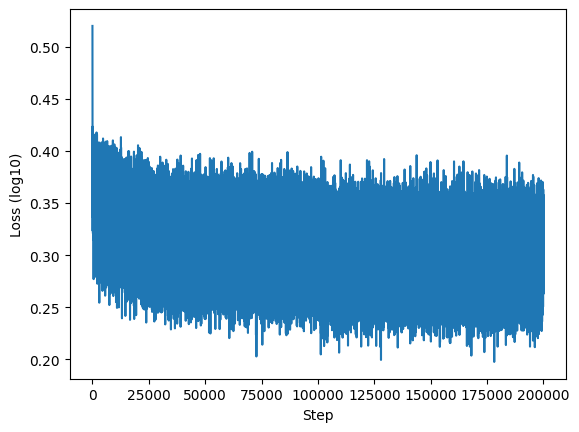

In [50]:
# Fix the huge initial loss.

num_neurons: Final[int] = 300
embed_dim: Final[int] = 30

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((char_cnt, embed_dim), generator=g).to(device)
# Scale down the initial weights.
W0 = torch.randn((block_size * embed_dim, char_cnt), generator=g).to(device) * 0.01
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g).to(device)
b1 = torch.randn(num_neurons, generator=g).to(device) * 0
W2 = torch.randn((num_neurons, char_cnt), generator=g).to(device) * 0.01
b2 = torch.randn(char_cnt, generator=g).to(device) * 0

parameters = [C, W0, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(f"parameters: {sum(p.nelement() for p in parameters)}")

@torch.no_grad()
def calculate_loss(X_t: torch.Tensor, Y_t: torch.Tensor) -> torch.Tensor:
    emb = C[X_t]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    # emb.view(-1, block_size * embed_dim) @ W0: Direct connection from
    # the input to the output.
    logits = b2 + emb.view(-1, block_size * embed_dim) @ W0 + h @ W2
    return F.cross_entropy(logits, Y_t)

epochs: Final[int] = 200000
loss = torch.tensor(1000.0)
reg_strength: Final[float] = 0.006
mini_batch_size: Final[int] = 128

lossi: list[float] = []
stepi = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = b2 + emb.view(-1, block_size * embed_dim) @ W0 + h @ W2
    # regularization = torch.tensor([w.pow(2).mean() for w in [W0, W1, b1, W2, b2]]).mean() * reg_strength
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch} / {epochs}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = (0.1 if epoch < 25000 else
          0.05 if epoch < 100000 else
          0.01 if epoch < 150000 else
          0.005 if epoch < 180000 else
          0.001)

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    stepi.append(epoch)
    lossi.append(loss.log10().item())

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")

plt.plot(stepi, lossi)
plt.xlabel("Step")
plt.ylabel("Loss (log10)")


In [54]:
names: list[str] = sample(20)
for name in names:
    print(name)

kristan.
avaccaleigh.
markatifan.
yastrydi.
lilaira.
ima.
dey.
aya.
kee.
emaynial.
azarieanyelle.
din.
prine.
kimani.
ayse.
sudgar.
reight.
livaahimick.
raharlynn.
jereman.


In [77]:
# Now look into h

# Fix the huge initial loss.

num_neurons: Final[int] = 300
embed_dim: Final[int] = 30

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((char_cnt, embed_dim), generator=g).to(device)
# Scale down the initial weights.
W0 = torch.randn((block_size * embed_dim, char_cnt), generator=g).to(device) * 0.01
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g).to(device) * 0.1
b1 = torch.randn(num_neurons, generator=g).to(device) * 0.1
W2 = torch.randn((num_neurons, char_cnt), generator=g).to(device) * 0.01
b2 = torch.randn(char_cnt, generator=g).to(device) * 0.1

parameters = [C, W0, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(f"parameters: {sum(p.nelement() for p in parameters)}")

@torch.no_grad()
def calculate_loss(X_t: torch.Tensor, Y_t: torch.Tensor) -> torch.Tensor:
    emb = C[X_t]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    # emb.view(-1, block_size * embed_dim) @ W0: Direct connection from
    # the input to the output.
    logits = b2 + emb.view(-1, block_size * embed_dim) @ W0 + h @ W2
    return F.cross_entropy(logits, Y_t)

epochs: Final[int] = 200000
loss = torch.tensor(1000.0)
reg_strength: Final[float] = 0.006
mini_batch_size: Final[int] = 128

lossi: list[float] = []
stepi = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    embcat = emb.view(-1, block_size * embed_dim)
    h_preact = embcat @ W1 + b1
    h = torch.tanh(h_preact)
    logits = b2 + emb.view(-1, block_size * embed_dim) @ W0 + h @ W2
    # regularization = torch.tensor([w.pow(2).mean() for w in [W0, W1, b1, W2, b2]]).mean() * reg_strength
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch} / {epochs}, Loss: {loss.item()}")

    break

# print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
# print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
# print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")

# plt.plot(stepi, lossi)
# plt.xlabel("Step")
# plt.ylabel("Loss (log10)")


parameters: 38667
Epoch: 0 / 200000, Loss: 3.322028875350952


(array([3.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+01, 9.000e+00,
        3.400e+01, 2.800e+01, 4.400e+01, 7.600e+01, 1.290e+02, 1.680e+02,
        3.560e+02, 4.160e+02, 5.460e+02, 8.030e+02, 1.023e+03, 1.276e+03,
        1.440e+03, 1.836e+03, 2.061e+03, 2.166e+03, 2.467e+03, 2.479e+03,
        2.571e+03, 2.642e+03, 2.551e+03, 2.303e+03, 2.065e+03, 1.751e+03,
        1.624e+03, 1.378e+03, 1.046e+03, 8.270e+02, 6.530e+02, 5.240e+02,
        3.070e+02, 2.530e+02, 2.150e+02, 1.070e+02, 8.700e+01, 6.000e+01,
        2.500e+01, 1.100e+01, 6.000e+00, 1.100e+01, 3.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00]),
 array([-4.10783815, -3.94107335, -3.77430855, -3.60754375, -3.44077894,
        -3.27401414, -3.10724934, -2.94048453, -2.77371973, -2.60695493,
        -2.44019012, -2.27342532, -2.10666052, -1.93989572, -1.77313091,
        -1.60636611, -1.43960131, -1.2728365 , -1.1060717 , -0.9393069 ,
        -0.7725421 , -0.60577729, -0.43901249, -0.27224769, -0.10548288,
         0.

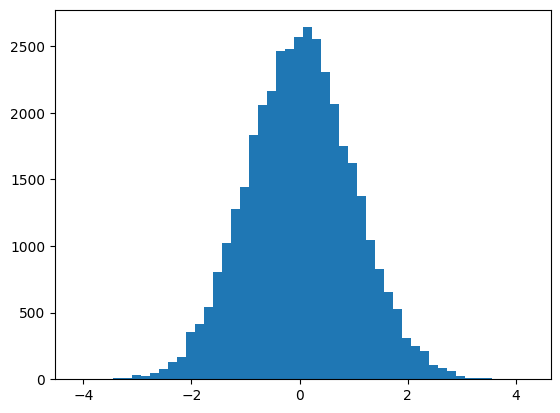

In [78]:
plt.hist(h_preact.view(-1).tolist(), 50)


(array([ 863., 1059., 1077.,  961., 1029.,  872.,  878.,  802.,  827.,
         724.,  808.,  737.,  661.,  652.,  715.,  697.,  684.,  637.,
         636.,  588.,  616.,  627.,  578.,  617.,  619.,  634.,  678.,
         634.,  649.,  636.,  669.,  754.,  609.,  660.,  648.,  666.,
         701.,  708.,  729.,  708.,  858.,  748.,  708.,  967.,  836.,
        1044.,  989., 1041., 1169.,  993.]),
 array([-9.99459386e-01, -9.59478661e-01, -9.19497936e-01, -8.79517211e-01,
        -8.39536486e-01, -7.99555761e-01, -7.59575036e-01, -7.19594311e-01,
        -6.79613585e-01, -6.39632860e-01, -5.99652135e-01, -5.59671410e-01,
        -5.19690685e-01, -4.79709960e-01, -4.39729235e-01, -3.99748510e-01,
        -3.59767785e-01, -3.19787060e-01, -2.79806335e-01, -2.39825610e-01,
        -1.99844885e-01, -1.59864160e-01, -1.19883435e-01, -7.99027097e-02,
        -3.99219847e-02,  5.87403774e-05,  4.00394654e-02,  8.00201905e-02,
         1.20000916e-01,  1.59981641e-01,  1.99962366e-01,  2.399430

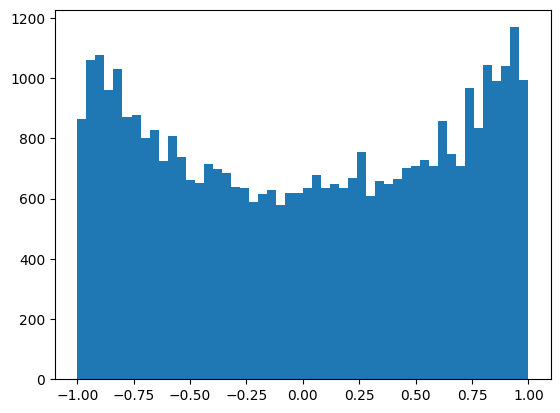

In [79]:
plt.hist(h.view(-1).tolist(), 50)

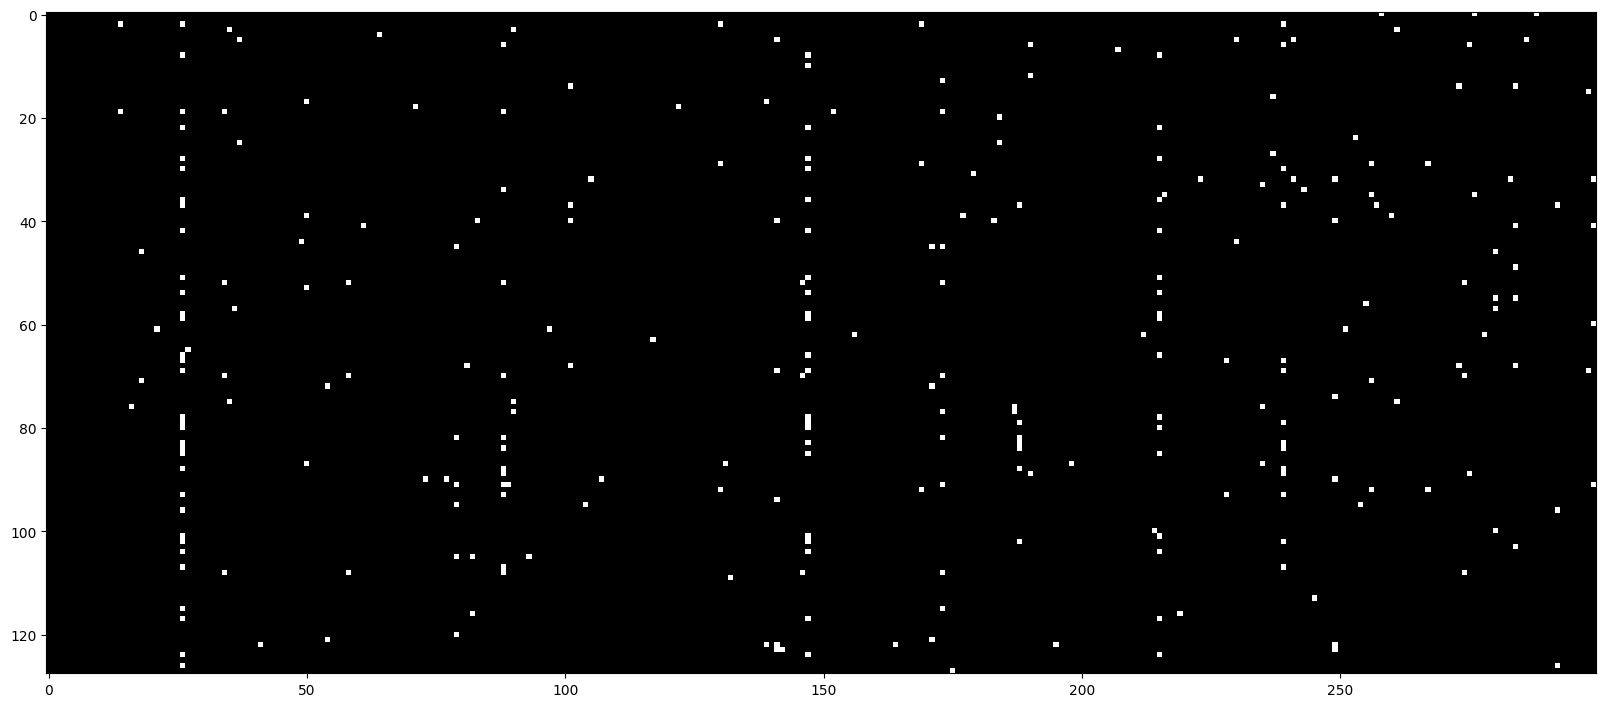

In [80]:
# Too many h takes extreme values.
h_cpu = h.to('cpu')
plt.figure(figsize=(20, 10))
plt.imshow(h_cpu.abs() > 0.99, cmap='gray', interpolation='nearest')

parameters: 38667
Epoch: 0 / 200000, Loss: 3.3295984268188477
Epoch: 1000 / 200000, Loss: 2.1357691287994385
Epoch: 2000 / 200000, Loss: 2.3013999462127686
Epoch: 3000 / 200000, Loss: 2.237058639526367
Epoch: 4000 / 200000, Loss: 2.1516597270965576
Epoch: 5000 / 200000, Loss: 2.086484909057617
Epoch: 6000 / 200000, Loss: 1.9661107063293457
Epoch: 7000 / 200000, Loss: 2.193760633468628
Epoch: 8000 / 200000, Loss: 2.4117045402526855
Epoch: 9000 / 200000, Loss: 2.0408003330230713
Epoch: 10000 / 200000, Loss: 1.9689829349517822
Epoch: 11000 / 200000, Loss: 2.1269218921661377
Epoch: 12000 / 200000, Loss: 2.2173094749450684
Epoch: 13000 / 200000, Loss: 2.126514434814453
Epoch: 14000 / 200000, Loss: 1.9458695650100708
Epoch: 15000 / 200000, Loss: 1.9551026821136475
Epoch: 16000 / 200000, Loss: 2.125109910964966
Epoch: 17000 / 200000, Loss: 2.150756597518921
Epoch: 18000 / 200000, Loss: 2.198391914367676
Epoch: 19000 / 200000, Loss: 2.1206984519958496
Epoch: 20000 / 200000, Loss: 2.12096023559

Text(0, 0.5, 'Loss (log10)')

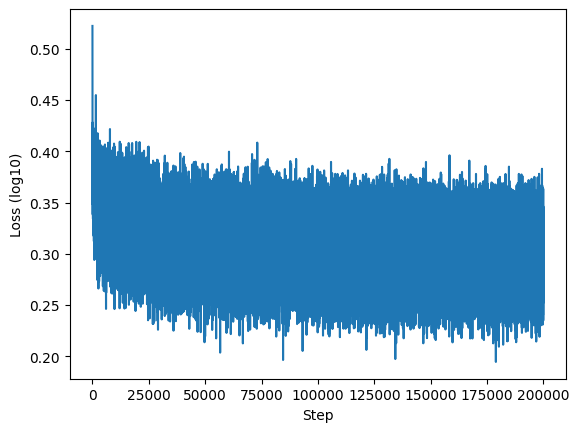

In [82]:
# Fix the huge initial loss.

num_neurons: Final[int] = 300
embed_dim: Final[int] = 30

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((char_cnt, embed_dim), generator=g).to(device)
# Scale down the initial weights.
W0 = torch.randn((block_size * embed_dim, char_cnt), generator=g).to(device) * 0.01
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g).to(device)
b1 = torch.randn(num_neurons, generator=g).to(device) * 0
W2 = torch.randn((num_neurons, char_cnt), generator=g).to(device) * 0.01
b2 = torch.randn(char_cnt, generator=g).to(device) * 0

parameters = [C, W0, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(f"parameters: {sum(p.nelement() for p in parameters)}")

@torch.no_grad()
def calculate_loss(X_t: torch.Tensor, Y_t: torch.Tensor) -> torch.Tensor:
    emb = C[X_t]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    # emb.view(-1, block_size * embed_dim) @ W0: Direct connection from
    # the input to the output.
    logits = b2 + emb.view(-1, block_size * embed_dim) @ W0 + h @ W2
    return F.cross_entropy(logits, Y_t)

epochs: Final[int] = 200000
loss = torch.tensor(1000.0)
reg_strength: Final[float] = 0.006
mini_batch_size: Final[int] = 128

lossi: list[float] = []
stepi = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = b2 + emb.view(-1, block_size * embed_dim) @ W0 + h @ W2
    # regularization = torch.tensor([w.pow(2).mean() for w in [W0, W1, b1, W2, b2]]).mean() * reg_strength
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch} / {epochs}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = (0.1 if epoch < 25000 else
          0.05 if epoch < 100000 else
          0.01 if epoch < 150000 else
          0.005 if epoch < 180000 else
          0.001)

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    stepi.append(epoch)
    lossi.append(loss.log10().item())

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")

plt.plot(stepi, lossi)
plt.xlabel("Step")
plt.ylabel("Loss (log10)")


x: -0.027895012870430946, 1.0087121725082397
y: -0.002513970946893096, 1.007121205329895


(array([2.19040892e-05, 6.57122677e-05, 2.19040892e-05, 4.38081785e-05,
        1.53328625e-04, 2.62849071e-04, 5.69506320e-04, 1.07330037e-03,
        1.75232714e-03, 3.85511970e-03, 5.95791227e-03, 8.58640298e-03,
        1.46757398e-02, 2.13345829e-02, 3.43675160e-02, 5.08612952e-02,
        8.04537197e-02, 1.10528034e-01, 1.59921755e-01, 2.14287705e-01,
        2.74633471e-01, 3.35921112e-01, 3.88074749e-01, 4.18324296e-01,
        4.20492801e-01, 3.98106822e-01, 3.51275879e-01, 2.92134838e-01,
        2.32249058e-01, 1.77423123e-01, 1.23429543e-01, 8.84487123e-02,
        6.11124089e-02, 4.07854141e-02, 2.64820439e-02, 1.71509019e-02,
        1.01196892e-02, 6.65884313e-03, 3.89892788e-03, 2.16850483e-03,
        1.31424535e-03, 7.00930855e-04, 4.16177695e-04, 3.06657249e-04,
        8.76163569e-05, 1.97136803e-04, 4.38081785e-05, 2.19040892e-05,
        0.00000000e+00, 4.38081785e-05]),
 array([-5.51860237, -5.29033449, -5.06206661, -4.83379873, -4.60553085,
        -4.37726297, 

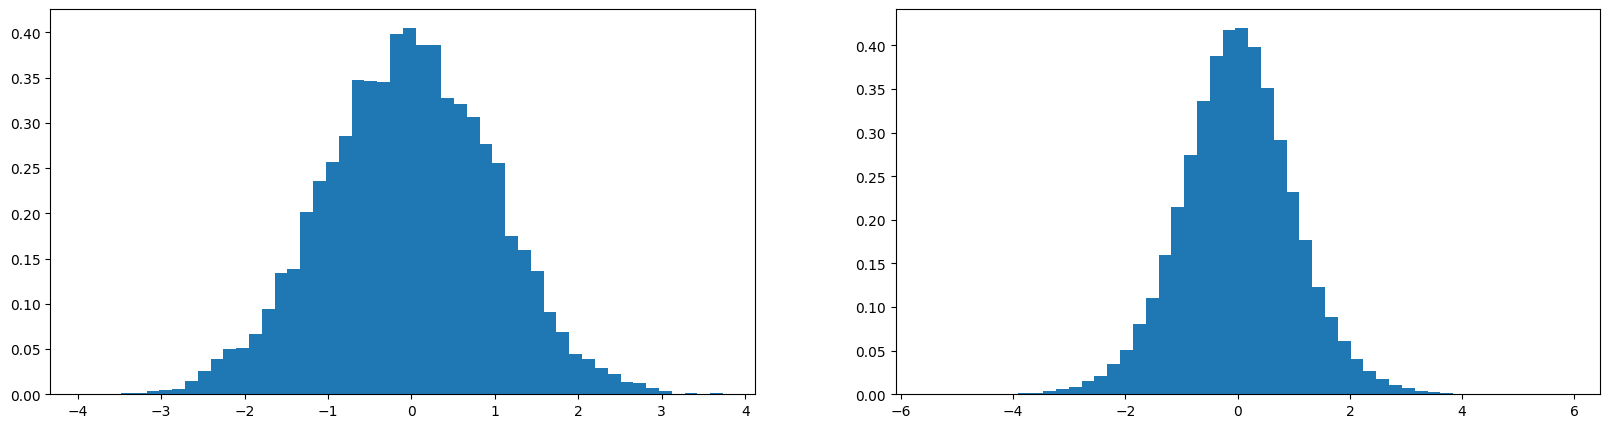

In [83]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / (10 ** 0.5)
y = x @ w
print(f"x: {x.mean()}, {x.std()}")
print(f"y: {y.mean()}, {y.std()}")
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), 50, density=True)

parameters: 36237
Epoch: 0 / 200000, Loss: 3.3213298320770264
Epoch: 1000 / 200000, Loss: 2.305577278137207
Epoch: 2000 / 200000, Loss: 2.1923112869262695
Epoch: 3000 / 200000, Loss: 2.2509281635284424
Epoch: 4000 / 200000, Loss: 2.2045352458953857
Epoch: 5000 / 200000, Loss: 2.1401960849761963
Epoch: 6000 / 200000, Loss: 2.1282835006713867
Epoch: 7000 / 200000, Loss: 2.305887460708618
Epoch: 8000 / 200000, Loss: 2.0075316429138184
Epoch: 9000 / 200000, Loss: 2.179826259613037
Epoch: 10000 / 200000, Loss: 2.046569347381592
Epoch: 11000 / 200000, Loss: 1.915731430053711
Epoch: 12000 / 200000, Loss: 2.076223611831665
Epoch: 13000 / 200000, Loss: 2.168839693069458
Epoch: 14000 / 200000, Loss: 2.0613009929656982
Epoch: 15000 / 200000, Loss: 2.1438117027282715
Epoch: 16000 / 200000, Loss: 2.1876914501190186
Epoch: 17000 / 200000, Loss: 2.1271278858184814
Epoch: 18000 / 200000, Loss: 2.0273685455322266
Epoch: 19000 / 200000, Loss: 2.114246129989624
Epoch: 20000 / 200000, Loss: 2.064893484115

Text(0, 0.5, 'Loss (log10)')

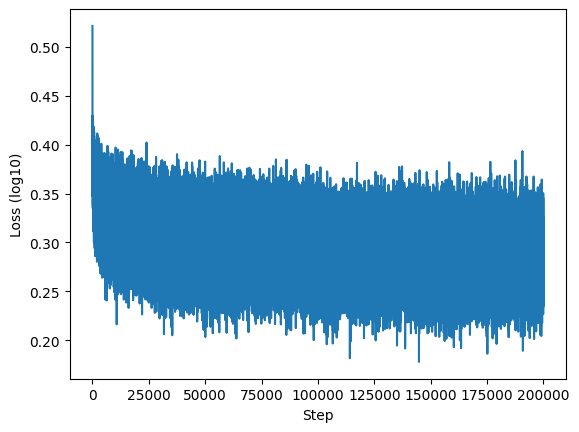

In [84]:
# Fix the huge initial loss.

num_neurons: Final[int] = 300
embed_dim: Final[int] = 30

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((char_cnt, embed_dim), generator=g).to(device)
# Scale down the initial weights.
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g).to(device) * (5 / 3) / ((embed_dim * block_size) ** 0.5)
b1 = torch.randn(num_neurons, generator=g).to(device) * 0.01
W2 = torch.randn((num_neurons, char_cnt), generator=g).to(device) * 0.01
b2 = torch.randn(char_cnt, generator=g).to(device) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(f"parameters: {sum(p.nelement() for p in parameters)}")

@torch.no_grad()
def calculate_loss(X_t: torch.Tensor, Y_t: torch.Tensor) -> torch.Tensor:
    emb = C[X_t]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    # emb.view(-1, block_size * embed_dim) @ W0: Direct connection from
    # the input to the output.
    logits = b2 + h @ W2
    return F.cross_entropy(logits, Y_t)

epochs: Final[int] = 200000
loss = torch.tensor(1000.0)
reg_strength: Final[float] = 0.006
mini_batch_size: Final[int] = 128

lossi: list[float] = []
stepi = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = b2 + h @ W2
    # regularization = torch.tensor([w.pow(2).mean() for w in [W0, W1, b1, W2, b2]]).mean() * reg_strength
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch} / {epochs}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = (0.1 if epoch < 25000 else
          0.05 if epoch < 100000 else
          0.01 if epoch < 150000 else
          0.005 if epoch < 180000 else
          0.001)

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    stepi.append(epoch)
    lossi.append(loss.log10().item())

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")

plt.plot(stepi, lossi)
plt.xlabel("Step")
plt.ylabel("Loss (log10)")


parameters: 36837
Epoch: 0 / 200000, Loss: 3.323671340942383
Epoch: 1000 / 200000, Loss: 2.373380422592163
Epoch: 2000 / 200000, Loss: 2.2899529933929443
Epoch: 3000 / 200000, Loss: 2.1132946014404297
Epoch: 4000 / 200000, Loss: 2.2962357997894287
Epoch: 5000 / 200000, Loss: 2.0921730995178223
Epoch: 6000 / 200000, Loss: 2.070227861404419
Epoch: 7000 / 200000, Loss: 2.1448771953582764
Epoch: 8000 / 200000, Loss: 2.0625383853912354
Epoch: 9000 / 200000, Loss: 2.223646402359009
Epoch: 10000 / 200000, Loss: 2.2691309452056885
Epoch: 11000 / 200000, Loss: 2.2388014793395996
Epoch: 12000 / 200000, Loss: 1.9136743545532227
Epoch: 13000 / 200000, Loss: 2.1936466693878174
Epoch: 14000 / 200000, Loss: 2.2347381114959717
Epoch: 15000 / 200000, Loss: 2.0703213214874268
Epoch: 16000 / 200000, Loss: 2.095283269882202
Epoch: 17000 / 200000, Loss: 1.9538707733154297
Epoch: 18000 / 200000, Loss: 2.0084962844848633
Epoch: 19000 / 200000, Loss: 2.047227621078491
Epoch: 20000 / 200000, Loss: 2.1566805839

Text(0, 0.5, 'Loss (log10)')

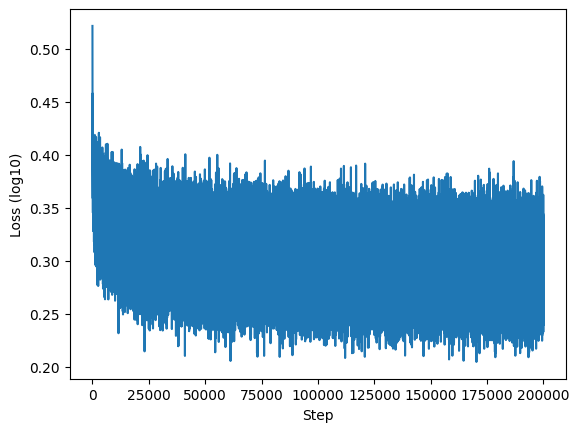

In [88]:
# Batch normalization

num_neurons: Final[int] = 300
embed_dim: Final[int] = 30

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((char_cnt, embed_dim), generator=g).to(device)
# Scale down the initial weights.
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g).to(device) * (5 / 3) / ((embed_dim * block_size) ** 0.5)
b1 = torch.randn(num_neurons, generator=g).to(device) * 0.01
W2 = torch.randn((num_neurons, char_cnt), generator=g).to(device) * 0.01
b2 = torch.randn(char_cnt, generator=g).to(device) * 0

bn_gain = torch.ones((1, num_neurons)).to(device)
bn_bias = torch.zeros((1, num_neurons)).to(device)

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
for p in parameters:
    p.requires_grad = True
print(f"parameters: {sum(p.nelement() for p in parameters)}")

@torch.no_grad()
def calculate_loss(X_t: torch.Tensor, Y_t: torch.Tensor) -> torch.Tensor:
    emb = C[X_t]
    embcat = emb.view(-1, block_size * embed_dim)
    h_preact = embcat @ W1 + b1
    # Do batch normalization.
    h_preact_mean = h_preact.mean(dim=0, keepdim=True)
    h_preact_std = h_preact.std(dim=0, keepdim=True)
    h_preact_norm = (h_preact - h_preact_mean) / h_preact_std
    h_preact = h_preact_norm * bn_gain + bn_bias
    h = torch.tanh(h_preact)
    logits = b2 + h @ W2
    return F.cross_entropy(logits, Y_t)

epochs: Final[int] = 200000
loss = torch.tensor(1000.0)
reg_strength: Final[float] = 0.006
mini_batch_size: Final[int] = 128

lossi: list[float] = []
stepi = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    embcat = emb.view(-1, block_size * embed_dim)
    h_preact = embcat @ W1 + b1
    # Do batch normalization.
    h_preact_mean = h_preact.mean(dim=0, keepdim=True)
    h_preact_std = h_preact.std(dim=0, keepdim=True)
    h_preact_norm = (h_preact - h_preact_mean) / h_preact_std
    h_preact = h_preact_norm * bn_gain + bn_bias
    h = torch.tanh(h_preact)
    logits = b2 + h @ W2
    # regularization = torch.tensor([w.pow(2).mean() for w in [W0, W1, b1, W2, b2]]).mean() * reg_strength
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch} / {epochs}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = (0.1 if epoch < 25000 else
          0.05 if epoch < 100000 else
          0.01 if epoch < 150000 else
          0.005 if epoch < 180000 else
          0.001)

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    stepi.append(epoch)
    lossi.append(loss.log10().item())

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")

plt.plot(stepi, lossi)
plt.xlabel("Step")
plt.ylabel("Loss (log10)")


In [108]:
# Calibrate the batch normalization at the end of the training.

@torch.no_grad()
def sample(num_samples: int) -> list[str]:
    C_cpu = C.to('cpu')
    W1_cpu = W1.to('cpu')
    b1_cpu = b1.to('cpu')
    W2_cpu = W2.to('cpu')
    b2_cpu = b2.to('cpu')

    with torch.no_grad():
        emb = C[X_train]
        embcat = emb.view(-1, block_size * embed_dim)
        h_preact = embcat @ W1 + b1
        h_preact_mean = h_preact.mean(dim=0, keepdim=True)
        h_preact_std = h_preact.std(dim=0, keepdim=True)

        h_preact_mean_cpu = h_preact_mean.to("cpu")
        h_preact_std_cpu = h_preact_std.to("cpu")
        bn_gain_cpu = bn_gain.to("cpu")
        bn_bias_cpu = bn_bias.to("cpu")

    names: list[str] = []
    for _ in range(num_samples):
        out: list[str] = []
        context: list[int] = [0] * block_size
        while True:
            emb = C_cpu[torch.tensor(context)]
            embcat = emb.view(1, -1)
            h_preact = embcat @ W1_cpu + b1_cpu
            h_preact_norm = (h_preact - h_preact_mean_cpu) / h_preact_std_cpu
            h = torch.tanh(h_preact_norm * bn_gain_cpu + bn_bias_cpu)
            logits = b2_cpu + h @ W2_cpu
            probs = F.softmax(logits, dim=1)
            ix: int = int(
                torch.multinomial(probs, num_samples=1).item()
            )
            context = context[1:] + [ix]
            out.append(itos[ix])
            if ix == 0:
                break
        names.append(''.join(out))
    return names

names: list[str] = sample(20)
for name in names:
    print(name[:-1])

maelill
lilan
lakeyer
anda
dra
emmattha
prechuyla
joh
hammadlavelyn
nirva
anter
cayleah
quilla
laiah
kayden
wren
kten
pie
talyn
vaya


parameters: 36837
Epoch: 0 / 200000, Loss: 3.3153629302978516
Epoch: 1000 / 200000, Loss: 2.247591733932495
Epoch: 2000 / 200000, Loss: 2.4223668575286865
Epoch: 3000 / 200000, Loss: 2.2499256134033203
Epoch: 4000 / 200000, Loss: 2.206374406814575
Epoch: 5000 / 200000, Loss: 2.158625841140747
Epoch: 6000 / 200000, Loss: 2.249346971511841
Epoch: 7000 / 200000, Loss: 2.156545877456665
Epoch: 8000 / 200000, Loss: 2.3243892192840576
Epoch: 9000 / 200000, Loss: 2.0002353191375732
Epoch: 10000 / 200000, Loss: 2.0613462924957275
Epoch: 11000 / 200000, Loss: 2.1759324073791504
Epoch: 12000 / 200000, Loss: 2.488473653793335
Epoch: 13000 / 200000, Loss: 2.1536524295806885
Epoch: 14000 / 200000, Loss: 2.0905160903930664
Epoch: 15000 / 200000, Loss: 2.2330832481384277
Epoch: 16000 / 200000, Loss: 2.0547935962677
Epoch: 17000 / 200000, Loss: 2.1513853073120117
Epoch: 18000 / 200000, Loss: 1.9533967971801758
Epoch: 19000 / 200000, Loss: 2.1669516563415527
Epoch: 20000 / 200000, Loss: 2.1975181102752

Text(0, 0.5, 'Loss (log10)')

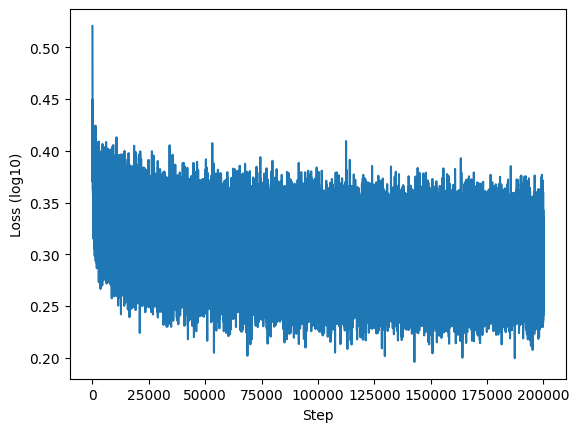

In [ ]:
# Batch normalization with running mean/std tracking.

num_neurons: Final[int] = 300
embed_dim: Final[int] = 30

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((char_cnt, embed_dim), generator=g).to(device)
# Scale down the initial weights.
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g).to(device) * (5 / 3) / ((embed_dim * block_size) ** 0.5)
b1 = torch.randn(num_neurons, generator=g).to(device) * 0.01
W2 = torch.randn((num_neurons, char_cnt), generator=g).to(device) * 0.01
b2 = torch.randn(char_cnt, generator=g).to(device) * 0

bn_gain = torch.ones((1, num_neurons)).to(device)
bn_bias = torch.zeros((1, num_neurons)).to(device)
bn_mean_running = torch.zeros((1, num_neurons)).to(device)
bn_std_running = torch.ones((1, num_neurons)).to(device)

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
for p in parameters:
    p.requires_grad = True
print(f"parameters: {sum(p.nelement() for p in parameters)}")

@torch.no_grad()
def calculate_loss(X_t: torch.Tensor, Y_t: torch.Tensor) -> torch.Tensor:
    emb = C[X_t]
    embcat = emb.view(-1, block_size * embed_dim)
    h_preact = embcat @ W1 + b1
    # Use the running mean/std.
    h_preact_norm = (h_preact - bn_mean_running) / bn_std_running
    h_preact = h_preact_norm * bn_gain + bn_bias
    h = torch.tanh(h_preact)
    logits = b2 + h @ W2
    return F.cross_entropy(logits, Y_t)

epochs: Final[int] = 200000
loss = torch.tensor(1000.0)
mini_batch_size: Final[int] = 128

lossi: list[float] = []
stepi = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    embcat = emb.view(-1, block_size * embed_dim)
    h_preact = embcat @ W1 + b1
    # Do batch normalization.
    h_preact_mean = h_preact.mean(dim=0, keepdim=True)
    h_preact_std = h_preact.std(dim=0, keepdim=True)
    h_preact_norm = (h_preact - h_preact_mean) / h_preact_std
    h_preact = h_preact_norm * bn_gain + bn_bias

    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * h_preact_mean
        bn_std_running = 0.999 * bn_std_running + 0.001 * h_preact_std

    h = torch.tanh(h_preact)
    logits = b2 + h @ W2
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch} / {epochs}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = (0.1 if epoch < 25000 else
          0.05 if epoch < 100000 else
          0.01 if epoch < 150000 else
          0.005 if epoch < 180000 else
          0.001)

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    stepi.append(epoch)
    lossi.append(loss.log10().item())

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")

plt.plot(stepi, lossi)
plt.xlabel("Step")
plt.ylabel("Loss (log10)")


In [112]:
# Calibrate the batch normalization at the end of the training.

@torch.no_grad()
def sample(num_samples: int) -> list[str]:
    C_cpu = C.to('cpu')
    W1_cpu = W1.to('cpu')
    b1_cpu = b1.to('cpu')
    W2_cpu = W2.to('cpu')
    b2_cpu = b2.to('cpu')

    bn_mean_running_cpu = bn_mean_running.to('cpu')
    bn_std_running_cpu = bn_std_running.to('cpu')
    bn_gain_cpu = bn_gain.to("cpu")
    bn_bias_cpu = bn_bias.to("cpu")

    names: list[str] = []
    for _ in range(num_samples):
        out: list[str] = []
        context: list[int] = [0] * block_size
        while True:
            emb = C_cpu[torch.tensor(context)]
            embcat = emb.view(1, -1)
            h_preact = embcat @ W1_cpu + b1_cpu
            h_preact_norm = (h_preact - bn_mean_running_cpu) / bn_std_running_cpu
            h = torch.tanh(h_preact_norm * bn_gain_cpu + bn_bias_cpu)
            logits = b2_cpu + h @ W2_cpu
            probs = F.softmax(logits, dim=1)
            ix: int = int(
                torch.multinomial(probs, num_samples=1).item()
            )
            context = context[1:] + [ix]
            out.append(itos[ix])
            if ix == 0:
                break
        names.append(''.join(out))
    return names

names: list[str] = sample(20)
for name in names:
    print(name[:-1])

vid
shamma
jaelys
aden
izabella
sha
sand
miresa
kadilynn
metrion
legeleckayristian
bowel
freigh
brayann
ram
neth
pherydnee
samanasse
aniya
nah


parameters: 36537
Epoch: 0 / 200000, Loss: 3.3121166229248047
Epoch: 1000 / 200000, Loss: 2.340257167816162
Epoch: 2000 / 200000, Loss: 2.277520179748535
Epoch: 3000 / 200000, Loss: 2.352112293243408
Epoch: 4000 / 200000, Loss: 2.2427902221679688
Epoch: 5000 / 200000, Loss: 2.1565630435943604
Epoch: 6000 / 200000, Loss: 2.3567581176757812
Epoch: 7000 / 200000, Loss: 1.9670631885528564
Epoch: 8000 / 200000, Loss: 2.1942880153656006
Epoch: 9000 / 200000, Loss: 2.0849013328552246
Epoch: 10000 / 200000, Loss: 2.2555088996887207
Epoch: 11000 / 200000, Loss: 2.0221686363220215
Epoch: 12000 / 200000, Loss: 2.1604480743408203
Epoch: 13000 / 200000, Loss: 2.0250933170318604
Epoch: 14000 / 200000, Loss: 2.1067864894866943
Epoch: 15000 / 200000, Loss: 1.9869016408920288
Epoch: 16000 / 200000, Loss: 2.156667470932007
Epoch: 17000 / 200000, Loss: 2.13214111328125
Epoch: 18000 / 200000, Loss: 1.857295274734497
Epoch: 19000 / 200000, Loss: 2.1345114707946777
Epoch: 20000 / 200000, Loss: 2.02323508262

Text(0, 0.5, 'Loss (log10)')

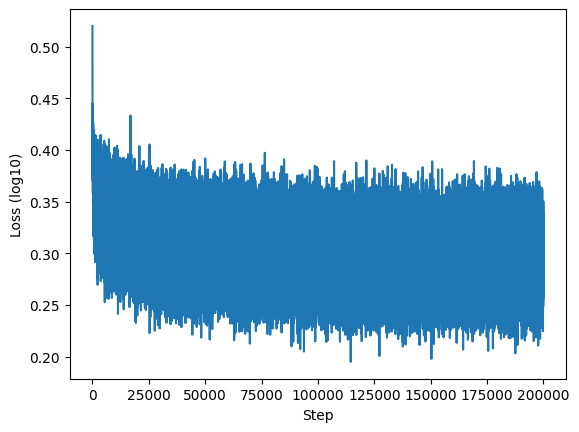

In [114]:
# No need for bias since we have batch normalization.

num_neurons: Final[int] = 300
embed_dim: Final[int] = 30

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((char_cnt, embed_dim), generator=g).to(device)
# Scale down the initial weights.
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g).to(device) * (5 / 3) / ((embed_dim * block_size) ** 0.5)
# Comment out bias since we have batch normalization.
# b1 = torch.randn(num_neurons, generator=g).to(device) * 0.01
W2 = torch.randn((num_neurons, char_cnt), generator=g).to(device) * 0.01
b2 = torch.randn(char_cnt, generator=g).to(device) * 0

bn_gain = torch.ones((1, num_neurons)).to(device)
bn_bias = torch.zeros((1, num_neurons)).to(device)
bn_mean_running = torch.zeros((1, num_neurons)).to(device)
bn_std_running = torch.ones((1, num_neurons)).to(device)

parameters = [C, W1, W2, b2, bn_gain, bn_bias]
for p in parameters:
    p.requires_grad = True
print(f"parameters: {sum(p.nelement() for p in parameters)}")

@torch.no_grad()
def calculate_loss(X_t: torch.Tensor, Y_t: torch.Tensor) -> torch.Tensor:
    emb = C[X_t]
    embcat = emb.view(-1, block_size * embed_dim)
    h_preact = embcat @ W1 + b1
    # Use the running mean/std.
    h_preact_norm = (h_preact - bn_mean_running) / bn_std_running
    h_preact = h_preact_norm * bn_gain + bn_bias
    h = torch.tanh(h_preact)
    logits = b2 + h @ W2
    return F.cross_entropy(logits, Y_t)

epochs: Final[int] = 200000
loss = torch.tensor(1000.0)
mini_batch_size: Final[int] = 128

lossi: list[float] = []
stepi = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    embcat = emb.view(-1, block_size * embed_dim)
    h_preact = embcat @ W1
    # Do batch normalization.
    h_preact_mean = h_preact.mean(dim=0, keepdim=True)
    h_preact_std = h_preact.std(dim=0, keepdim=True)
    h_preact_norm = (h_preact - h_preact_mean) / h_preact_std
    h_preact = h_preact_norm * bn_gain + bn_bias

    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * h_preact_mean
        bn_std_running = 0.999 * bn_std_running + 0.001 * h_preact_std

    h = torch.tanh(h_preact)
    logits = b2 + h @ W2
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch} / {epochs}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = (0.1 if epoch < 25000 else
          0.05 if epoch < 100000 else
          0.01 if epoch < 150000 else
          0.005 if epoch < 180000 else
          0.001)

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    stepi.append(epoch)
    lossi.append(loss.log10().item())

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")

plt.plot(stepi, lossi)
plt.xlabel("Step")
plt.ylabel("Loss (log10)")
